In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf

import sys
sys.path.append('/mnt/c/Users/kheut/code/covid19-forecasting/tf_model_1p5/')

from enum import Enum

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense

import tensorflow_probability as tfp
from scipy.stats import beta, truncnorm


# Local imports from model.py, data.py
from model import CovidModel, LogPoissonProb, get_logging_callbacks, Comp, Vax
from data import read_data, create_warmup
#from plots import make_all_plots

import scipy

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20}) # set plot font sizes

2021-11-29 12:24:51.561470: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-29 12:24:51.561502: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
transition_window =3

warmup_start = '20210329'
warmup_end = '20210331'
train_start = '20210401'
train_end = '20210831'
test_start = '20210901'
test_end = '20210931'

state = 'Massachusetts'
state_abbrev = 'MA'

data_dir = '../data'
covid_estim_date = '20210901'
hhs_date = '20210903'
owid_date = '20210903'

log_dir = './logs/new_warmup'


# Learning rate
learning_rate = 1e-4

In [3]:
df = read_data(data_dir=data_dir,
               covid_estim_date=covid_estim_date,
               hhs_date=hhs_date,
               owid_date=owid_date,
               state=state, state_abbrev=state_abbrev)

In [4]:
class Comp(Enum):
    A = 0
    M = 1
    #X = 2
    #G = 3
    
class Vax(Enum):
    total = -1
    no = 0
    yes = 1

In [5]:
# get warmup arrays, splitting on vaccination status
warmup_asymp, warmup_mild, warmup_extreme = create_warmup(df, 
                                                          warmup_start, 
                                                          warmup_end,
                                                          0,0,0)

# re-combine
warmup_asymp = warmup_asymp[Vax.no.value] + warmup_asymp[Vax.yes.value]

In [6]:
x_train = tf.cast(df.loc[train_start:train_end,'Rt'].values, dtype=tf.float32)
y_test = tf.cast(df.loc[train_start:train_end,'mild'], dtype=tf.float32)

2021-11-29 12:24:54.978936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-29 12:24:54.979121: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-29 12:24:54.979150: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-11-29 12:24:54.979173: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-11-29 12:24:54.979194: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [7]:
synth_delta = 0.99
synth_T_serial = 5.8
synth_rho_M = 0.76
synth_lambda_M = 4.7
synth_nu_M = 3.1

In [8]:

model_delta = 0.995
model_T_serial = 5.3
model_rho_M = 0.8
model_lambda_M = 5.0
model_nu_M = 2.6
model_asymp = warmup_asymp+50

In [9]:
A_vals = []
M_vals =[]
for day in range(transition_window):
    A_vals.append(warmup_asymp[day])

for day in range(len(x_train)):
    yesterday_asymp = A_vals[-1]
    
    today_asymp = yesterday_asymp*synth_delta*x_train[day]**(1/synth_T_serial)
    A_vals.append(today_asymp)
    
    today_M = 0
    pi_M=[]
    for j in range(transition_window):
        
        
        lambda_M_fix = synth_lambda_M
        nu_M_fix = synth_nu_M
        poisson_dist = scipy.stats.poisson(lambda_M_fix)
        pi_M_j_ago = poisson_dist.logpmf(j+1)/nu_M_fix
        
        pi_M.append(pi_M_j_ago)
    
    pi_M = scipy.special.softmax(pi_M)
        
    for j in range(transition_window):
        j_ago_asymp = A_vals[day-j-1]
        today_M += j_ago_asymp*synth_rho_M*pi_M[j]
        
    M_vals.append(today_M)

In [10]:
param_scale_pcts = np.logspace(-5, -1, 20, dtype=np.float32)
trials = 5

losses = {}
for param_scale_pct in param_scale_pcts:
    print(f'New pct!: {param_scale_pct}')
    losses[param_scale_pct] = []
    for trial in range(trials):
        delta = {}
        delta[Vax.total.value] = {}
        delta[Vax.total.value]['prior'] = {'a': 18, 'b': 2}
        # delta is 0-1, so we will sigmoid the output of the variational posterior
        # Here we use a reverse sigmoid to convert from a mean of 0.1
        # scales are positive, so we invert sofplus


        delta[Vax.total.value]['posterior_init'] = {'loc': np.log(model_delta/(1-synth_delta)),
                                                    'scale':tf.cast(tfp.math.softplus_inverse(param_scale_pct*synth_delta),dtype=tf.float32)}

        T_serial = {}
        T_serial[Vax.total.value] = {}
        T_serial[Vax.total.value]['prior'] ={'loc':5.8, 'scale':1}
        # T_serial is positive, so we will softplus the output of the variational posterior
        # Here we use a reverse softplus to convert from a mean of 5.8
        # I cant figure out the math to do for the scale parameter
        T_serial[Vax.total.value]['posterior_init'] = {'loc': tfp.math.softplus_inverse(synth_T_serial),
                                                 'scale':tf.cast(tfp.math.softplus_inverse(param_scale_pct*synth_T_serial),dtype=tf.float32)}


        rho_M = {}
        rho_M[Vax.total.value] = {}
        rho_M[Vax.total.value]['prior'] = {'a': 31.8, 'b': 10.3}
        # rho is 0-1, so we will sigmoid the output of the variational posterior
        # Here we use a reverse sigmoid to convert from a mean of 0.76
        # I cant figure out the math to do for the scale parameter
        rho_M[Vax.total.value]['posterior_init'] = {'loc': np.log(synth_rho_M/(1-synth_rho_M)),
                                              'scale':tf.cast(tfp.math.softplus_inverse(param_scale_pct*synth_rho_M),dtype=tf.float32)}

        lambda_M = {}
        lambda_M[Vax.total.value] = {}
        lambda_M[Vax.total.value]['prior'] = {'loc': 4.7, 'scale': 1}
        # lambda is positive, so we will softplus the output of the variational posterior
        # Here we use a reverse softplus to convert from a mean of 4.7
        # I cant figure out the math to do for the scale parameter
        lambda_M[Vax.total.value]['posterior_init'] = {'loc': tfp.math.softplus_inverse(synth_lambda_M),
                                                 'scale':tf.cast(tfp.math.softplus_inverse(param_scale_pct*synth_lambda_M),dtype=tf.float32)}

        nu_M = {}
        nu_M[Vax.total.value] = {}
        nu_M[Vax.total.value]['prior'] = {'loc': 3.1, 'scale': 1.2}
        # nu is positive, so we will softplus the output of the variational posterior
        # Here we use a reverse softplus to convert from a mean of 3.1
        # I cant figure out the math to do for the scale parameter
        nu_M[Vax.total.value]['posterior_init'] = {'loc': tfp.math.softplus_inverse(synth_nu_M),
                                             'scale':tf.cast(tfp.math.softplus_inverse(param_scale_pct*synth_nu_M),dtype=tf.float32)}

        warmup_A_params = {}
        warmup_A_params[Vax.total.value] = {}
        warmup_A_params[Vax.total.value]['prior'] = []
        warmup_A_params[Vax.total.value]['posterior_init'] = []

        for day in range(transition_window):
            warmup_A_params[Vax.total.value]['prior'].append({'loc': warmup_asymp[day],
                                                        'scale': warmup_asymp[day]/10})
            # must be positive so reverse softplus the mean
            warmup_A_params[Vax.total.value]['posterior_init'].append({'loc': tf.cast(tfp.math.softplus_inverse(warmup_asymp[day]),dtype=tf.float32),
                                                                 'scale': tf.cast(tfp.math.softplus_inverse(warmup_asymp[day]*param_scale_pct),dtype=tf.float32)})#tf.cast(tfp.math.softplus_inverse(warmup_asymp[day]/10),dtype=tf.float32)})
            
        model = CovidModel([Vax.total], [Comp.A, Comp.M],
                         transition_window,
                         delta, T_serial, rho_M, lambda_M, nu_M,
                         warmup_A_params, posterior_samples=1000)
        loss = LogPoissonProb() 
        optimizer = tf.keras.optimizers.SGD(
            learning_rate=learning_rate, #momentum=0.98, nesterov=False, name='SGD'
        )
        
       

        with tf.GradientTape() as tape:
            result = model.call(x_train)
            loss_val = loss(tf.cast(np.array(M_vals),dtype=tf.float32), result)
            loss_val += sum(model.losses)
            
        losses[param_scale_pct].append(loss_val)
        

New pct!: 9.999999747378752e-06
delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.6001577>
delta_scale: 9.899997166940011e-06
Pre-softmax pi_M [[-1.0169036  -1.0168996  -1.0169234  ... -1.0169122  -1.0169178
  -1.0169041 ]
 [-0.74128896 -0.741286   -0.7413034  ... -0.7412952  -0.7412993
  -0.7412893 ]
 [-0.5964684  -0.5964672  -0.5964782  ... -0.5964743  -0.596478
  -0.59646934]]
Delta 0.9900493621826172
T serial 5.7997894287109375
rho_M 0.7599946856498718
lambda M 4.6998724937438965
pi_M [[0.2604191  0.2604195  0.26041758 ... 0.2604186  0.26041827 0.26041913]
 [0.34306055 0.34306067 0.34306037 ... 0.34306067 0.3430608  0.3430606 ]
 [0.3965204  0.39651984 0.39652205 ... 0.3965207  0.39652097 0.39652026]]


2021-11-04 09:17:28.481965: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.6001577>
delta_scale: 9.899997166940011e-06
Pre-softmax pi_M [[-1.0169039  -1.0169141  -1.0169021  ... -1.0169278  -1.0169102
  -1.0169195 ]
 [-0.74128914 -0.7412966  -0.7412878  ... -0.7413066  -0.7412937
  -0.74130046]
 [-0.5964694  -0.59647393 -0.5964676  ... -0.5964808  -0.59647214
  -0.5964761 ]]
Delta 0.9900493621826172
T serial 5.799790859222412
rho_M 0.759995698928833
lambda M 4.699862957000732
pi_M [[0.26041913 0.26041833 0.2604192  ... 0.26041725 0.26041865 0.26041788]
 [0.3430606  0.3430605  0.34306052 ... 0.3430604  0.34306055 0.3430604 ]
 [0.39652017 0.39652118 0.39652026 ... 0.3965223  0.39652082 0.39652175]]
delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.6001577>
delta_scale: 9.899997166940011e-06


KeyboardInterrupt: 

In [ ]:
losses

In [ ]:
plt.plot(param_scale_pcts[:10],
         [losses[param_scale_pct] for param_scale_pct in param_scale_pcts[:10]], 'k.')
plt.xscale('log')
plt.xlabel('Std. Dev. as a percentage of of mean')
plt.ylabel('Negative ELBO')
plt.title("Performance vs Parameter Std. Deviation")

In [ ]:
import copy;
trials = 10
possibilities = {
    'delta': [0.98, 0.985, 0.99, 0.995, 0.998],
    'T_serial': [3.0, 4.5, 5.8, 7.0, 9.0],
    'rho_M': [0.5, 0.65, 0.76, 0.8, 0.9],
    'lambda_M': [2.0, 3.0, 4.7, 6.0, 9.0],
    'nu_M': [1.5, 2.5, 3.1, 4.0, 5.0],
    'warmup_asymp_-3': copy.copy([warmup_asymp[0]-400, warmup_asymp[0]-200, warmup_asymp[0], warmup_asymp[0]+200, warmup_asymp[0]+400]),
    'warmup_asymp_-2': copy.copy([warmup_asymp[1]-400, warmup_asymp[1]-200, warmup_asymp[1], warmup_asymp[1]+200, warmup_asymp[1]+400]),
    'warmup_asymp_-1': copy.copy([warmup_asymp[2]-400, warmup_asymp[2]-200, warmup_asymp[2], warmup_asymp[2]+200, warmup_asymp[2]+400]),
}

diff_pcts = np.linspace(0, 0.20, 20)
param_scale_pct = 0.005
losses = {}
grad_mag = {}
just_model_losses ={}
just_pis = {}
for key in possibilities.keys():
    print(f'New key!: {key}')
    model_delta = synth_delta
    model_T_serial = synth_T_serial
    model_rho_M = synth_rho_M
    model_lambda_M = synth_lambda_M
    model_nu_M = synth_nu_M
    model_asymp = copy.copy(warmup_asymp)
    
    losses[key] = []
    grad_mag[key] = []
    just_model_losses[key] = []
    just_pis[key] = []
    
    for diff_idx in range(5):
        model_asymp =  copy.copy(warmup_asymp)

        if key =='delta':
            model_delta = possibilities[key][diff_idx]
        if key =='T_serial':
            model_T_serial = possibilities[key][diff_idx]
        if key =='rho_M':
            model_rho_M = possibilities[key][diff_idx]
        if key =='lambda_M':
            model_lambda_M = possibilities[key][diff_idx]
        if key =='nu_M':
            model_nu_M = possibilities[key][diff_idx]
        if key =='warmup_asymp_-3':
            model_asymp[0] = possibilities[key][diff_idx]
        if key =='warmup_asymp_-2':
            model_asymp[1] = possibilities[key][diff_idx]
        if key =='warmup_asymp_-1':
            model_asymp[2] = possibilities[key][diff_idx]

            

        
        for trial in range(trials):



            delta = {}
            delta[Vax.total.value] = {}
            delta[Vax.total.value]['prior'] = {'a': 18, 'b': 2}
            # delta is 0-1, so we will sigmoid the output of the variational posterior
            # Here we use a reverse sigmoid to convert from a mean of 0.1
            # scales are positive, so we invert sofplus


            delta[Vax.total.value]['posterior_init'] = {'loc': tf.cast(np.log(model_delta/(1-model_delta)),dtype=tf.float32),
                                                        'scale':tf.cast(tfp.math.softplus_inverse(param_scale_pct*model_delta),dtype=tf.float32)}

            T_serial = {}
            T_serial[Vax.total.value] = {}
            T_serial[Vax.total.value]['prior'] ={'loc':5.8, 'scale':1}
            # T_serial is positive, so we will softplus the output of the variational posterior
            # Here we use a reverse softplus to convert from a mean of 5.8
            # I cant figure out the math to do for the scale parameter
            T_serial[Vax.total.value]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(model_T_serial),dtype=tf.float32),
                                                     'scale':tf.cast(tfp.math.softplus_inverse(param_scale_pct*model_T_serial),dtype=tf.float32)}


            rho_M = {}
            rho_M[Vax.total.value] = {}
            rho_M[Vax.total.value]['prior'] = {'a': 31.8, 'b': 10.3}
            # rho is 0-1, so we will sigmoid the output of the variational posterior
            # Here we use a reverse sigmoid to convert from a mean of 0.76
            # I cant figure out the math to do for the scale parameter
            rho_M[Vax.total.value]['posterior_init'] = {'loc': tf.cast(np.log(model_rho_M/(1-model_rho_M)),dtype=tf.float32),
                                                  'scale':tf.cast(tfp.math.softplus_inverse(param_scale_pct*model_rho_M),dtype=tf.float32)}

            lambda_M = {}
            lambda_M[Vax.total.value] = {}
            lambda_M[Vax.total.value]['prior'] = {'loc': 4.7, 'scale': 1}
            # lambda is positive, so we will softplus the output of the variational posterior
            # Here we use a reverse softplus to convert from a mean of 4.7
            # I cant figure out the math to do for the scale parameter
            lambda_M[Vax.total.value]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(model_lambda_M),dtype=tf.float32),
                                                     'scale':tf.cast(tfp.math.softplus_inverse(param_scale_pct*model_lambda_M),dtype=tf.float32)}

            nu_M = {}
            nu_M[Vax.total.value] = {}
            nu_M[Vax.total.value]['prior'] = {'loc': 3.1, 'scale': 1.2}
            # nu is positive, so we will softplus the output of the variational posterior
            # Here we use a reverse softplus to convert from a mean of 3.1
            # I cant figure out the math to do for the scale parameter
            nu_M[Vax.total.value]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(model_nu_M),dtype=tf.float32),
                                                 'scale':tf.cast(tfp.math.softplus_inverse(param_scale_pct*model_nu_M),dtype=tf.float32)}

            warmup_A_params = {}
            warmup_A_params[Vax.total.value] = {}
            warmup_A_params[Vax.total.value]['prior'] = []
            warmup_A_params[Vax.total.value]['posterior_init'] = []

            for day in range(transition_window):
                warmup_A_params[Vax.total.value]['prior'].append({'loc': warmup_asymp[day],
                                                            'scale': warmup_asymp[day]/10})
                # must be positive so reverse softplus the mean
                warmup_A_params[Vax.total.value]['posterior_init'].append({'loc': tf.cast(tfp.math.softplus_inverse(model_asymp[day]),dtype=tf.float32),
                                                                     'scale': tf.cast(tfp.math.softplus_inverse(model_asymp[day]*param_scale_pct),dtype=tf.float32)})#tf.cast(tfp.math.softplus_inverse(warmup_asymp[day]/10),dtype=tf.float32)})

            model = CovidModel([Vax.total], [Comp.A, Comp.M],
                             transition_window,
                             delta, T_serial, rho_M, lambda_M, nu_M,
                             warmup_A_params, posterior_samples=1000)
            loss = LogPoissonProb() 
            optimizer = tf.keras.optimizers.SGD(
                learning_rate=learning_rate, #momentum=0.98, nesterov=False, name='SGD'
            )



            with tf.GradientTape() as tape:
                result = model.call(x_train)
                loss_val = loss(tf.cast(np.array(M_vals),dtype=tf.float32), result)
                loss_val += sum(model.losses)

            grads = tape.gradient(loss_val, model.trainable_weights)

            losses[key].append(loss_val)
            grad_mag[key].append(np.mean(grads))
            just_model_losses[key].append(model.losses)
            just_pis[key].append(tf.reduce_mean(model.pi_M_samples, axis=1))



In [ ]:
plt.plot(diff_pcts,
         [losses[diff_pct] for diff_pct in diff_pcts], 'k.')
plt.xscale('log')
plt.xlabel('Std. Dev. as a percentage of of mean')
plt.ylabel('Negative ELBO')
plt.title("Performance vs % Deviation from Truth")

In [ ]:
plt.plot(diff_pcts,
         [grad_mag[diff_pct] for diff_pct in diff_pcts], 'k.')
plt.xscale('log')
plt.xlabel('Abs % difference from True Parameters')
plt.ylabel('Average Gradient')
plt.title("Gradient Magnitude vs % Deviation from Truth")

In [ ]:
grad_mag

In [ ]:
result

In [ ]:
plt.plot(np.repeat(possibilities['delta'],10),
         losses['delta'], 'k.')
plt.plot([synth_delta, synth_delta], [20, 40], 'r-', label='Truth')
plt.xlabel('Delta Mean')
plt.ylabel('Negative Elbo')
plt.legend()
plt.title("Loss vs. Mean Delta value")

In [ ]:
plt.plot(np.repeat(possibilities['T_serial'],10),
         losses['T_serial'], 'k.')
plt.plot([model_T_serial, model_T_serial], [20, 30], 'r-', label='Truth')
plt.xlabel('T_serial Mean')
plt.ylabel('Negative Elbo')
plt.legend()
plt.title("Loss vs. Mean T_serial value")

In [ ]:

plt.plot(np.repeat(possibilities['rho_M'],10),
         losses['rho_M'], 'k.')
plt.plot([synth_rho_M, synth_rho_M], [20, 25], 'r-', label='Truth')
plt.xlabel('rho_M Mean')
plt.ylabel('Negative Elbo')
plt.legend()
plt.title("Loss vs. Mean rho_M value")

In [ ]:

plt.plot(np.repeat(possibilities['lambda_M'],10),
         losses['lambda_M'], 'k.')
plt.plot([synth_lambda_M, synth_lambda_M], [20, 30], 'r-', label='Truth')
plt.xlabel('lambda_M Mean')
plt.ylabel('Negative Elbo')
plt.legend()
plt.title("Loss vs. Mean lambda_M value")

In [ ]:

plt.plot(np.repeat(possibilities['nu_M'],10),
         losses['nu_M'], 'k.')
plt.plot([model_nu_M, model_nu_M], [21, 21.5], 'r-', label='Truth')
plt.xlabel('nu_M Mean')
plt.ylabel('Negative Elbo')
plt.legend()
plt.title("Loss vs. Mean nu_M value")

In [ ]:

plt.plot(np.repeat(possibilities['warmup_asymp_-3'],10),
         losses['warmup_asymp_-3'], 'k.')
plt.plot([warmup_asymp[0], warmup_asymp[0]], [21, 21.1], 'r-', label='Truth')
plt.xlabel('Warmup A t-3 Mean')
plt.ylabel('Negative Elbo')
plt.legend()
plt.title("Loss vs. Mean Warmup A t-3 value")

In [ ]:

plt.plot(np.repeat(possibilities['warmup_asymp_-2'],10),
         losses['warmup_asymp_-2'], 'k.')
plt.plot([warmup_asymp[1], warmup_asymp[1]], [20.9, 21.1], 'r-', label='Truth')
plt.xlabel('Warmup A t-2 Mean')
plt.ylabel('Negative Elbo')
plt.legend()
plt.title("Loss vs. Mean Warmup A t-2 value")

In [ ]:

plt.plot(np.repeat(possibilities['warmup_asymp_-1'],10),
         losses['warmup_asymp_-1'], 'k.')
plt.plot([warmup_asymp[2], warmup_asymp[2]], [21, 25], 'r-', label='Truth')
plt.xlabel('Warmup A t-1 Mean')
plt.ylabel('Negative Elbo')
plt.legend()
plt.title("Loss vs. Mean Warmup A t-1 value")

In [25]:
import copy;
trials = 5
possibilities = {
    'delta': synth_delta*np.logspace(-8,-1,20),
    'T_serial': np.logspace(-8,-1,20),
    'rho_M': [0.5, 0.65, 0.76, 0.8, 0.9],
    'lambda_M': [2.0, 3.0, 4.7, 6.0, 9.0],
    'nu_M': [1.5, 2.5, 3.1, 4.0, 5.0],
    'warmup_asymp_-3': copy.copy([warmup_asymp[0]-400, warmup_asymp[0]-200, warmup_asymp[0], warmup_asymp[0]+200, warmup_asymp[0]+400]),
    'warmup_asymp_-2': copy.copy([warmup_asymp[1]-400, warmup_asymp[1]-200, warmup_asymp[1], warmup_asymp[1]+200, warmup_asymp[1]+400]),
    'warmup_asymp_-1': copy.copy([warmup_asymp[2]-400, warmup_asymp[2]-200, warmup_asymp[2], warmup_asymp[2]+200, warmup_asymp[2]+400]),
}

diff_pcts = np.linspace(0, 0.20, 20)
param_scale_pct = 0.005
losses = {}
grad_mag = {}
just_model_losses ={}
just_pis = {}
for key in ['T_serial']:#possibilities.keys():
    print(f'New key!: {key}')
    model_delta = synth_delta
    model_T_serial = synth_T_serial
    model_rho_M = synth_rho_M
    model_lambda_M = synth_lambda_M
    model_nu_M = synth_nu_M
    model_asymp = copy.copy(warmup_asymp)
    
    losses[key] = []
    grad_mag[key] = []
    just_model_losses[key] = []
    just_pis[key] = []
    
    for diff_idx in range(len(possibilities[key])):
        model_asymp =  copy.copy(warmup_asymp)
        
        delta_pct = param_scale_pct
        T_serial_pct = param_scale_pct
        rho_M_pct = param_scale_pct
        lambda_M_pct = param_scale_pct
        nu_M_pct = param_scale_pct
        asymp_3_pct = param_scale_pct
        asymp_2_pct = param_scale_pct
        asymp_1_pct = param_scale_pct

        if key =='delta':
            delta_pct  = possibilities[key][diff_idx]
        if key =='T_serial':
            T_serial_pct = possibilities[key][diff_idx]
        if key =='rho_M':
            rho_M_pct = possibilities[key][diff_idx]
        if key =='lambda_M':
            lambda_M_pct = possibilities[key][diff_idx]
        if key =='nu_M':
            nu_M_pct = possibilities[key][diff_idx]
        if key =='warmup_asymp_-3':
            asymp_3_pct = possibilities[key][diff_idx]
        if key =='warmup_asymp_-2':
            asymp_2_pct = possibilities[key][diff_idx]
        if key =='warmup_asymp_-1':
            asymp_1_pct = possibilities[key][diff_idx]

            

        
        for trial in range(trials):



            delta = {}
            delta[Vax.total.value] = {}
            delta[Vax.total.value]['prior'] = {'a': 18, 'b': 2}
            # delta is 0-1, so we will sigmoid the output of the variational posterior
            # Here we use a reverse sigmoid to convert from a mean of 0.1
            # scales are positive, so we invert sofplus


            delta[Vax.total.value]['posterior_init'] = {'loc': tf.cast(np.log(model_delta/(1-model_delta)),dtype=tf.float32),
                                                        'scale':tf.cast(tfp.math.softplus_inverse(delta_pct*model_delta),dtype=tf.float32)}

            T_serial = {}
            T_serial[Vax.total.value] = {}
            T_serial[Vax.total.value]['prior'] ={'loc':5.8, 'scale':1}
            # T_serial is positive, so we will softplus the output of the variational posterior
            # Here we use a reverse softplus to convert from a mean of 5.8
            # I cant figure out the math to do for the scale parameter
            T_serial[Vax.total.value]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(model_T_serial),dtype=tf.float32),
                                                     'scale':tf.cast(tfp.math.softplus_inverse(T_serial_pct*model_T_serial),dtype=tf.float32)}


            rho_M = {}
            rho_M[Vax.total.value] = {}
            rho_M[Vax.total.value]['prior'] = {'a': 31.8, 'b': 10.3}
            # rho is 0-1, so we will sigmoid the output of the variational posterior
            # Here we use a reverse sigmoid to convert from a mean of 0.76
            # I cant figure out the math to do for the scale parameter
            rho_M[Vax.total.value]['posterior_init'] = {'loc': tf.cast(np.log(model_rho_M/(1-model_rho_M)),dtype=tf.float32),
                                                  'scale':tf.cast(tfp.math.softplus_inverse(rho_M_pct*model_rho_M),dtype=tf.float32)}

            lambda_M = {}
            lambda_M[Vax.total.value] = {}
            lambda_M[Vax.total.value]['prior'] = {'loc': 4.7, 'scale': 1}
            # lambda is positive, so we will softplus the output of the variational posterior
            # Here we use a reverse softplus to convert from a mean of 4.7
            # I cant figure out the math to do for the scale parameter
            lambda_M[Vax.total.value]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(model_lambda_M),dtype=tf.float32),
                                                     'scale':tf.cast(tfp.math.softplus_inverse(lambda_M_pct*model_lambda_M),dtype=tf.float32)}

            nu_M = {}
            nu_M[Vax.total.value] = {}
            nu_M[Vax.total.value]['prior'] = {'loc': 3.1, 'scale': 1.2}
            # nu is positive, so we will softplus the output of the variational posterior
            # Here we use a reverse softplus to convert from a mean of 3.1
            # I cant figure out the math to do for the scale parameter
            nu_M[Vax.total.value]['posterior_init'] = {'loc': tf.cast(tfp.math.softplus_inverse(model_nu_M),dtype=tf.float32),
                                                 'scale':tf.cast(tfp.math.softplus_inverse(nu_M_pct*model_nu_M),dtype=tf.float32)}

            warmup_A_params = {}
            warmup_A_params[Vax.total.value] = {}
            warmup_A_params[Vax.total.value]['prior'] = []
            warmup_A_params[Vax.total.value]['posterior_init'] = []

            for day in range(transition_window):
                if day ==0:
                    asymp_pct =asymp_3_pct
                elif day ==1:
                    asymp_pct =asymp_2_pct
                else:
                    asymp_pct = asymp_1_pct
                warmup_A_params[Vax.total.value]['prior'].append({'loc': warmup_asymp[day],
                                                            'scale': warmup_asymp[day]/10})
                # must be positive so reverse softplus the mean
                warmup_A_params[Vax.total.value]['posterior_init'].append({'loc': tf.cast(tfp.math.softplus_inverse(model_asymp[day]),dtype=tf.float32),
                                                                     'scale': tf.cast(tfp.math.softplus_inverse(model_asymp[day]*asymp_pct),dtype=tf.float32)})#tf.cast(tfp.math.softplus_inverse(warmup_asymp[day]/10),dtype=tf.float32)})

            model = CovidModel([Vax.total], [Comp.A, Comp.M],
                             transition_window,
                             delta, T_serial, rho_M, lambda_M, nu_M,
                             warmup_A_params, posterior_samples=1000)
            loss = LogPoissonProb() 
            optimizer = tf.keras.optimizers.SGD(
                learning_rate=learning_rate, #momentum=0.98, nesterov=False, name='SGD'
            )



            with tf.GradientTape() as tape:
                result = model.call(x_train)
                loss_val = loss(tf.cast(np.array(M_vals),dtype=tf.float32), result)
                loss_val += sum(model.losses)

            grads = tape.gradient(loss_val, model.trainable_weights)

            losses[key].append(loss_val)
            grad_mag[key].append(np.mean(grads))
            just_model_losses[key].append(model.losses)
            just_pis[key].append(tf.reduce_mean(model.pi_M_samples, axis=1))



New key!: T_serial
delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0049500009045004845
Pre-softmax pi_M [[-1.0063063  -1.0149351  -1.010095   ... -1.0130736  -1.0170443
  -1.0137498 ]
 [-0.73356307 -0.7398534  -0.73634136 ... -0.73849696 -0.7413938
  -0.7390001 ]
 [-0.5907089  -0.5958742  -0.59422857 ... -0.5942123  -0.59627426
  -0.5938513 ]]
Delta 0.9897849559783936
T serial 5.800000190734863
rho_M 0.757775068283081
lambda M 4.625814437866211
pi_M [[0.2611758  0.26060864 0.26105747 ... 0.26067442 0.2603813  0.2605518 ]
 [0.34307086 0.3431273  0.34326205 ... 0.34304062 0.34302306 0.34293863]
 [0.39575335 0.39626405 0.39568046 ... 0.39628494 0.39659563 0.39650962]]
delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0049500009045004845
Pre-softmax pi_M [[-1.016651   -1.015053   -1.0235057  ... -1.0286219  -1.0006679
  -1.0237254 ]
 [-0.74110484 -0.7399398  -0.74610597 ... -0.7498306  -0.729462

delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0049500009045004845
Pre-softmax pi_M [[-1.0117037  -1.0279478  -1.0193684  ... -1.0241983  -1.0193145
  -1.0051084 ]
 [-0.7375027  -0.74935645 -0.7430864  ... -0.7466166  -0.74304837
  -0.7326987 ]
 [-0.5945495  -0.6018909  -0.5978103  ... -0.59997743 -0.5976376
  -0.5909247 ]]
Delta 0.9898582100868225
T serial 5.799999237060547
rho_M 0.7579960823059082
lambda M 4.632649898529053
pi_M [[0.26088434 0.25957337 0.26024356 ... 0.2598528  0.26023272 0.26135182]
 [0.343188   0.3429658  0.34305817 ... 0.3429885  0.3430384  0.34318754]
 [0.39592767 0.3974608  0.39669833 ... 0.39715874 0.3967289  0.39546058]]
delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0049500009045004845
Pre-softmax pi_M [[-1.0223378  -1.0212103  -1.0177633  ... -1.022713   -1.021284
  -1.0362916 ]
 [-0.74525356 -0.7444334  -0.7419152  ... -0.74552953 -0.74450314
  -0.7554416 ]
 

delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0049500009045004845
Pre-softmax pi_M [[-1.0083828  -1.016282   -1.0245538  ... -1.0225909  -1.0165714
  -1.019856  ]
 [-0.73507756 -0.7408348  -0.74687403 ... -0.74543566 -0.7410499
  -0.74344116]
 [-0.59147215 -0.59643656 -0.60027325 ... -0.5996795  -0.5959383
  -0.59820384]]
Delta 0.9898178577423096
T serial 5.799994468688965
rho_M 0.7577292323112488
lambda M 4.613590717315674
pi_M [[0.26098973 0.26049498 0.25983787 ... 0.26002592 0.26040697 0.26022202]
 [0.34301916 0.343103   0.34300247 ... 0.34307072 0.34301263 0.34307528]
 [0.3959911  0.39640203 0.39715967 ... 0.3969033  0.3965804  0.39670274]]
delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0049500009045004845
Pre-softmax pi_M [[-1.0080873  -1.0249342  -1.0216074  ... -1.005261   -1.0154815
  -1.0281085 ]
 [-0.7348674  -0.74718255 -0.7447174  ... -0.732801   -0.7402513
  -0.7494778 ]
 [

delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0049500009045004845
Pre-softmax pi_M [[-1.0180223  -1.0223347  -1.0126773  ... -1.0087063  -1.0063692
  -1.0107585 ]
 [-0.7421034  -0.74524707 -0.73820746 ... -0.7353128  -0.7336119
  -0.73680896]
 [-0.59740114 -0.59998715 -0.5941254  ... -0.5917787  -0.5912281
  -0.59347075]]
Delta 0.9898676872253418
T serial 5.799914836883545
rho_M 0.7578871250152588
lambda M 4.630209922790527
pi_M [[0.2603727  0.26009014 0.26071593 ... 0.26098007 0.2612217  0.26089308]
 [0.3431038  0.34313223 0.34305862 ... 0.34303674 0.34313598 0.34311312]
 [0.39652348 0.39677757 0.39622545 ... 0.39598316 0.39564234 0.39599374]]
delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0049500009045004845
Pre-softmax pi_M [[-1.0245059  -1.0160453  -1.015014   ... -1.0258209  -1.0139607
  -1.0202987 ]
 [-0.74684864 -0.7406635  -0.7399135  ... -0.747799   -0.73914266
  -0.74376285]
 

delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0049500009045004845
Pre-softmax pi_M [[-1.0126586  -1.0072722  -1.0159345  ... -1.0166076  -1.0178523
  -1.0188996 ]
 [-0.73820287 -0.7342689  -0.7405854  ... -0.741078   -0.7419798
  -0.74274826]
 [-0.5953746  -0.5916194  -0.59557045 ... -0.59582466 -0.5971708
  -0.59720105]]
Delta 0.9897967576980591
T serial 5.799611568450928
rho_M 0.7578567266464233
lambda M 4.627671718597412
pi_M [[0.26084816 0.26114675 0.26045015 ... 0.26039076 0.26037064 0.2602407 ]
 [0.3432277  0.34312195 0.34301037 ... 0.34299403 0.34308517 0.34300956]
 [0.39592406 0.39573127 0.39653948 ... 0.39661518 0.39654425 0.39674968]]
delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0049500009045004845
Pre-softmax pi_M [[-1.0088403  -1.0254987  -1.0161474  ... -1.0231278  -1.0326129
  -1.0147432 ]
 [-0.73541003 -0.7475829  -0.7407434  ... -0.7458252  -0.752755
  -0.73971385]
 [-

delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0049500009045004845
Pre-softmax pi_M [[-1.012698   -1.0175822  -1.0200367  ... -1.0221553  -1.0137553
  -1.0141822 ]
 [-0.7382226  -0.74178493 -0.7435742  ... -0.74512535 -0.7389933
  -0.73930496]
 [-0.5941357  -0.5966932  -0.5981306  ... -0.5988759  -0.5947512
  -0.5955283 ]]
Delta 0.9898360967636108
T serial 5.795280456542969
rho_M 0.7577841281890869
lambda M 4.628277778625488
pi_M [[0.26071435 0.26035595 0.2601915  ... 0.25999913 0.2606431  0.26066893]
 [0.34305844 0.34303996 0.34305143 ... 0.3429924  0.343063   0.34313655]
 [0.39622718 0.39660412 0.396757   ... 0.3970085  0.39629394 0.39619446]]
delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0049500009045004845
Pre-softmax pi_M [[-1.0293884  -1.0145007  -1.0142698  ... -1.0062864  -1.0034839
  -1.0255862 ]
 [-0.7504001  -0.73953813 -0.7393845  ... -0.73355    -0.7315098
  -0.7476286 ]
 [

delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0049500009045004845
Pre-softmax pi_M [[-1.0223904  -1.0167242  -1.02455    ... -1.0117742  -1.0267873
  -1.0120767 ]
 [-0.7452947  -0.74115777 -0.74686867 ... -0.7375529  -0.7485085
  -0.7377695 ]
 [-0.5991317  -0.5964212  -0.6004242  ... -0.5931197  -0.6012884
  -0.594098  ]]
Delta 0.989836573600769
T serial 5.775310516357422
rho_M 0.7577967047691345
lambda M 4.636075973510742
pi_M [[0.2599954  0.26043704 0.25985372 ... 0.26072758 0.25965878 0.26078966]
 [0.34301    0.34306765 0.34302387 ... 0.34298864 0.34297144 0.34309986]
 [0.39699456 0.3964953  0.3971224  ... 0.39628378 0.39736977 0.39611042]]
delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0049500009045004845
Pre-softmax pi_M [[-1.0029255  -1.013525   -1.023579   ... -1.0104858  -1.018406
  -1.017731  ]
 [-0.7310985  -0.7388251  -0.7461624  ... -0.73660976 -0.7423945
  -0.7418912 ]
 [-0

delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0049500009045004845
Pre-softmax pi_M [[-1.0148815  -1.0093697  -1.0211874  ... -1.0312469  -1.0206461
  -1.0077988 ]
 [-0.739814   -0.73579633 -0.74441284 ... -0.75175726 -0.7440265
  -0.7346524 ]
 [-0.595759   -0.5921887  -0.5988269  ... -0.6039942  -0.5979278
  -0.59189487]]
Delta 0.9898301959037781
T serial 5.6650261878967285
rho_M 0.7581009864807129
lambda M 4.625959396362305
pi_M [[0.26060358 0.26093778 0.26011673 ... 0.2593701  0.26009363 0.261108  ]
 [0.34311575 0.34304285 0.34305993 ... 0.3430052  0.3429763  0.34312013]
 [0.3962807  0.3960193  0.3968233  ... 0.39762473 0.39693004 0.39577192]]
delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0049500009045004845
Pre-softmax pi_M [[-1.0256816  -1.0288712  -1.0036633  ... -1.0136926  -1.0179241
  -1.0175118 ]
 [-0.74769497 -0.7500366  -0.73166317 ... -0.7389496  -0.7420386
  -0.7417427 ]
 

delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0049500009045004845
Pre-softmax pi_M [[-1.0194576  -1.0157855  -1.0143138  ... -1.0124552  -1.0025904
  -1.0322262 ]
 [-0.74315006 -0.7404729  -0.7394086  ... -0.73804736 -0.7308616
  -0.7524798 ]
 [-0.59810215 -0.5962398  -0.59431577 ... -0.59470063 -0.5893491
  -0.6042341 ]]
Delta 0.9898358583450317
T serial 3.6129438877105713
rho_M 0.7575287222862244
lambda M 4.632753849029541
pi_M [[0.2602622  0.26053798 0.26052764 ... 0.26080385 0.2615103  0.259271  ]
 [0.3430915  0.34311345 0.3429601  ... 0.343153   0.34316197 0.34296224]
 [0.39664632 0.39634866 0.39651227 ... 0.39604315 0.39532772 0.39776683]]
delta_loc: <tf.Variable 'delta_A_loc_-1:0' shape=() dtype=float32, numpy=4.59512>
delta_scale: 0.0049500009045004845
Pre-softmax pi_M [[-1.006459   -1.0302135  -1.0187155  ... -1.0169659  -1.0074754
  -1.0185246 ]
 [-0.7336744  -0.7510061  -0.74261653 ... -0.7413357  -0.73441607
  -0.74246967]


In [26]:
plt.plot(np.repeat(possibilities['delta'],5),
         losses['delta'], 'k.')
#plt.plot([synth_delta*param_scale_pct, synth_delta*param_scale_pct], [21, 21.5], 'r-', label='Truth')
plt.xlabel('Delta Mean')
plt.ylabel('Negative Elbo')
#plt.legend()
plt.xscale('log')
plt.title("Loss vs. Mean Delta value")

KeyError: 'delta'

Text(0.5, 1.0, 'Loss vs. T Serial Std. Dev')

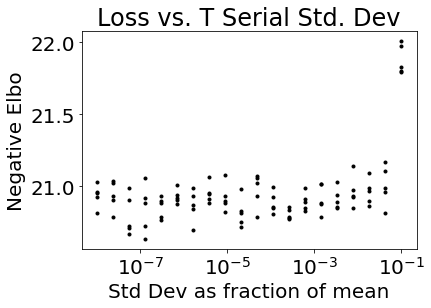

In [38]:
plt.plot(np.repeat(possibilities['T_serial'],5),
         losses['T_serial'], 'k.')
#plt.plot([synth_delta*param_scale_pct, synth_delta*param_scale_pct], [21, 21.5], 'r-', label='Truth')
plt.xlabel('Std Dev as fraction of mean')
plt.ylabel('Negative Elbo')
#plt.legend()
plt.xscale('log')
plt.title("Loss vs. T Serial Std. Dev")

In [33]:
[model_loss[2] for model_loss in just_model_losses['T_serial']]

[<tf.Tensor: shape=(), dtype=float32, numpy=-1.5175884>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.5032172>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.4775288>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.5047021>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.503436>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.490261>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.5522326>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.515553>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.5339972>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.4988167>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.5140908>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.5211828>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.5213369>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.5097966>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.4986796>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.5058229>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-1.527042>,
 <tf.Tensor: shape=(), dtype=float3

Text(0.5, 1.0, 'Prior component of loss')

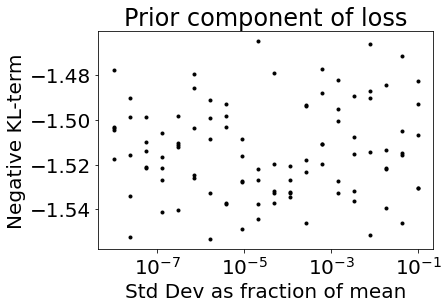

In [39]:
plt.plot(np.repeat(possibilities['T_serial'],5),
         [model_loss[2] for model_loss in just_model_losses['T_serial']], 'k.')
#plt.plot([synth_delta*param_scale_pct, synth_delta*param_scale_pct], [21, 21.5], 'r-', label='Truth')
plt.xlabel('Std Dev as fraction of mean')
plt.ylabel('Negative KL-term')
#plt.legend()
plt.xscale('log')
plt.title("Prior component of loss")

In [ ]:
warmup_asymp

In [ ]:
model.losses

In [ ]:
model_delta

In [ ]:
possibilities['delta']

In [ ]:
synth_delta

In [ ]:
param_scale_pct

In [ ]:
plt.plot(df.loc[train_start:train_end].index.values, tf.reduce_mean(result,axis=1))
plt.plot(df.loc[train_start:train_end].index.values, M_vals)

In [ ]:
model_delta

In [ ]:
tf.nn.softmax(tf.cast([[1,2,3,4],[4,10,20,2],[4,10,20,2]],dtype=tf.float32),
             axis=0)

In [ ]:
possibilities['lambda_M']

In [ ]:
tfp.math.softplus_inverse(8.0)

In [ ]:
model.losses

In [ ]:
just_model_losses

In [ ]:
losses

In [ ]:
model.pi_M_samples

In [ ]:
just_pis

In [ ]:
result.shape

In [ ]:
tf.reduce_mean(result,axis=1).shape

In [22]:
losses

{'delta': [<tf.Tensor: shape=(), dtype=float32, numpy=20.696945>,
  <tf.Tensor: shape=(), dtype=float32, numpy=20.823496>,
  <tf.Tensor: shape=(), dtype=float32, numpy=21.00198>,
  <tf.Tensor: shape=(), dtype=float32, numpy=20.96514>,
  <tf.Tensor: shape=(), dtype=float32, numpy=20.842182>,
  <tf.Tensor: shape=(), dtype=float32, numpy=20.891277>,
  <tf.Tensor: shape=(), dtype=float32, numpy=20.871475>,
  <tf.Tensor: shape=(), dtype=float32, numpy=20.927456>,
  <tf.Tensor: shape=(), dtype=float32, numpy=20.899502>,
  <tf.Tensor: shape=(), dtype=float32, numpy=20.749352>,
  <tf.Tensor: shape=(), dtype=float32, numpy=20.799656>,
  <tf.Tensor: shape=(), dtype=float32, numpy=20.769405>,
  <tf.Tensor: shape=(), dtype=float32, numpy=20.936996>,
  <tf.Tensor: shape=(), dtype=float32, numpy=21.041227>,
  <tf.Tensor: shape=(), dtype=float32, numpy=20.992802>,
  <tf.Tensor: shape=(), dtype=float32, numpy=20.90212>,
  <tf.Tensor: shape=(), dtype=float32, numpy=20.915657>,
  <tf.Tensor: shape=(), d